# Conformer ASR Inference With CTC Decoder

Performing speech recognition inference using a CTC Beam Search Decoder with lexicon constrain and KenLM language model support.

## Overview

Beam search decoding works by iteratively expanding text hypotheses (beams) with next possible characters, and maintaining only the hypotheses with the highest scores at each time step. A language model can be incorporated into the scoring computation, and adding a lexicon constraint restricts the next possible tokens for the hypotheses so that only words from the lexicon can be generated.

Running ASR inference using a CTC Beam Search decoder with a language model and lexicon constraint requires the following components

- __Acoustic Model:__ model predicting phonetics from audio waveforms

- __Tokens:__ the possible predicted tokens from the acoustic model

- __Lexicon:__ mapping between possible words and their corresponding tokens sequence

- __Language Model (LM):__ n-gram language model trained with the KenLM library, or custom language model that inherits CTCDecoderLM

## Acoustic Model and Set Up

In [ ]:
!pip install flashlight-text --quiet

In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.5.0+cu121
2.5.0+cu121


In [ ]:
import time
from typing import List

import IPython
import matplotlib.pyplot as plt
from torchaudio.models.decoder import ctc_decoder
from torchaudio.utils import download_asset

In [ ]:
# Downloading the trained model
!gdown https://drive.google.com/uc?id=1XcouMWSncUeNBvGZednuWYK1jdfKisCr

Downloading...
From (original): https://drive.google.com/uc?id=1XcouMWSncUeNBvGZednuWYK1jdfKisCr
From (redirected): https://drive.google.com/uc?id=1XcouMWSncUeNBvGZednuWYK1jdfKisCr&confirm=t&uuid=9be5664b-4f1e-4372-80f8-180e36569766
To: /content/Conformer-epoch=24-val_wer=0.23.ckpt
100% 118M/118M [00:03<00:00, 33.4MB/s]


In [ ]:
from collections import OrderedDict
from torch import nn
from model import ConformerEncoder, LSTMDecoder

class SpeechRecognition(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super(SpeechRecognition, self).__init__()
        self.encoder = ConformerEncoder(**encoder_params)
        self.decoder = LSTMDecoder(**decoder_params)

    def forward(self, x):
        # print(x.shape)
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output)
        return decoder_output

In [ ]:
# Hyper parameters of trained_model (conformer small)
# https://arxiv.org/pdf/2005.08100 : Table 1 for conformer parameters
encoder_params = {
    'd_input': 80,                        # Input features: n-mels
    'd_model': 144,                       # Encoder Dims
    'num_layers': 16,                     # Encoder Layers
    'conv_kernel_size': 31,
    'feed_forward_residual_factor': 0.5,
    'feed_forward_expansion_factor': 4,
    'num_heads': 4,                       # Relative MultiHead Attetion Heads
    'dropout': 0.1,
}

decoder_params = {
    'd_encoder': 144,    # Match with Encoder layer
    'd_decoder': 320,    # Decoder Dim
    'num_layers': 1,     # Deocder Layer
    'num_classes': 29,   # Output Classes
}

acoustic_model = SpeechRecognition(encoder_params, decoder_params)

In [ ]:
# Load speech recognition model
ckpt_path = "/content/Conformer-epoch=24-val_wer=0.23.ckpt"
checkpoint = torch.load(ckpt_path, map_location="cpu")

# Load the state dict into the model
model_state_dict = checkpoint['state_dict']
encoder_state_dict = OrderedDict()
decoder_state_dict = OrderedDict()

for k, v in model_state_dict.items():
        if k.startswith('model.encoder.'):
            name = k.replace('model.encoder.', '')  # Remove 'encoder.' prefix
            encoder_state_dict[name] = v
        elif k.startswith('model.decoder.'):
            name = k.replace('model.decoder.', '')   # Remove 'decoder.' prefix
            decoder_state_dict[name] = v

acoustic_model.encoder.load_state_dict(encoder_state_dict)
acoustic_model.decoder.load_state_dict(decoder_state_dict)

# Set the model to evaluation mode
acoustic_model.eval()

<ipython-input-5-54d3a8f8984e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cpu")


SpeechRecognition(
  (encoder): ConformerEncoder(
    (conv_subsample): Conv2dSubsampling(
      (module): Sequential(
        (0): Conv2d(1, 144, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
        (2): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2))
        (3): ReLU()
      )
    )
    (linear_proj): Linear(in_features=2736, out_features=144, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-15): 16 x ConformerBlock(
        (ff1): FeedForwardBlock(
          (module): Sequential(
            (0): LayerNorm((144,), eps=6.1e-05, elementwise_affine=True)
            (1): Linear(in_features=144, out_features=576, bias=True)
            (2): SiLU()
            (3): Dropout(p=0.1, inplace=False)
            (4): Linear(in_features=576, out_features=144, bias=True)
            (5): Dropout(p=0.1, inplace=False)
          )
        )
        (attention): RelativeMultiHeadAttention(
          (W_q): Linear(in_features=144, out_features

In [ ]:
# Load a sample from the LibriSpeech test-other dataset.
speech_file = download_asset("tutorial-assets/ctc-decoding/1688-142285-0007.wav")
IPython.display.Audio(speech_file)

The transcript corresponds to:

```
i really was very much afraid of showing him how much shocked i was at some parts of what he said
```

In [ ]:
import numpy as np
import torchaudio.transforms as transforms

class LogMelSpec(nn.Module):
    def __init__(self, sample_rate=16000, n_mels=80, hop_length=160):
        super(LogMelSpec, self).__init__()
        self.transform = transforms.MelSpectrogram(sample_rate=sample_rate,
                                                   n_mels=n_mels,
                                                   hop_length=hop_length)

    def forward(self, x):
        x = self.transform(x)            # Mel spectrogram Conversion
        return x


def get_featurizer(sample_rate=16000, n_mels=80, hop_length=160):
    return LogMelSpec(sample_rate=sample_rate,
                      n_mels=n_mels,
                      hop_length=hop_length)

In [ ]:
waveform, _ = torchaudio.load(speech_file)
waveform_tensor = waveform[0]
waveform.shape

torch.Size([1, 112960])

In [ ]:
waveform = get_featurizer()(waveform).unsqueeze(1)
waveform.shape

torch.Size([1, 1, 80, 707])

## Files and Data for Decoder

Next, we load in our token, lexicon, and language model data, which are used by the decoder to predict words from the acoustic model output. Pretrained files for the LibriSpeech dataset can be downloaded through torchaudio, or the user can provide their own files.

### 1. Tokens
The tokens are the possible symbols that the acoustic model can predict, including the blank and silent symbols. It can either be passed in as a file, where each line consists of the tokens corresponding to the same index, or as a list of tokens, each mapping to a unique index.

In [ ]:
%%writefile tokens.txt
'

a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
_

Overwriting tokens.txt


In [ ]:
token_file_path = 'tokens.txt'

with open(token_file_path, 'r') as file:
    tokens = file.read().splitlines()

## 2. Lexicon

The lexicon is a mapping from words to their corresponding tokens sequence, and is used to restrict the search space of the decoder to only words from the lexicon. The expected format of the lexicon file is a line per word, with a word followed by its space-split tokens.

## 3. Language Model

A language model can be used in decoding to improve the results, by factoring in a language model score that represents the likelihood of the sequence into the beam search computation. Below, we outline the different forms of language models that are supported for decoding.

In [ ]:
from torchaudio.models.decoder import CTCDecoderLM, CTCDecoderLMState

class CustomLM(CTCDecoderLM):
    """Create a Python wrapper around `language_model` to feed to the decoder."""

    def __init__(self, language_model: torch.nn.Module):
        CTCDecoderLM.__init__(self)
        self.language_model = language_model
        self.sil = -1  # index for silent token in the language model
        self.states = {}

        language_model.eval()

    def start(self, start_with_nothing: bool = False):
        state = CTCDecoderLMState()
        with torch.no_grad():
            score = self.language_model(self.sil)

        self.states[state] = score
        return state

    def score(self, state: CTCDecoderLMState, token_index: int):
        outstate = state.child(token_index)
        if outstate not in self.states:
            score = self.language_model(token_index)
            self.states[outstate] = score
        score = self.states[outstate]

        return outstate, score

    def finish(self, state: CTCDecoderLMState):
        return self.score(state, self.sil)

In [ ]:
from torchaudio.models.decoder import download_pretrained_files

# Download pre trained Ken Language Model
files = download_pretrained_files("librispeech-4-gram")
print(files)

PretrainedFiles(lexicon='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lexicon.txt', tokens='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/tokens.txt', lm='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lm.bin')


## Construct Greedy Decoder

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> List[str]:
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          List[str]: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        joined = "".join([self.labels[i] for i in indices])
        return joined.replace("_", "").strip().split()


greedy_decoder = GreedyCTCDecoder(tokens)

## Run Inference

In [ ]:
waveform, _ = torchaudio.load(speech_file)

waveform = get_featurizer()(waveform)
print(waveform.shape)

waveform = waveform.permute(0, 2, 1)
print(waveform.shape)

torch.Size([1, 80, 707])
torch.Size([1, 707, 80])


In [ ]:
import torch.nn.functional as F

original_transcript = "i really was very much afraid of showing him how much shocked i was at some parts of what he said"
actual_transcript = original_transcript.split()

# Pass the audio inputs to model
emission = acoustic_model(waveform)
emission

tensor([[[-2.1108, -5.1849, -0.1222,  ..., -0.7508, -3.5257,  9.7504],
         [-2.6529, -7.0735, -0.0150,  ..., -1.1626, -5.9708, 12.3004],
         [-2.0424, -7.0909, -0.1027,  ..., -2.2402, -6.6313, 12.8043],
         ...,
         [-2.7321, -1.2842, -1.4977,  ..., -2.0178, -7.2900, 12.2821],
         [-2.6602, -0.6139, -1.4042,  ..., -1.9990, -6.9266, 12.1514],
         [-2.6566,  0.8826, -1.5064,  ..., -2.2247, -6.5506, 11.8598]]],
       grad_fn=<ViewBackward0>)

In [ ]:
class Color:
    YELLOW = '\033[33m'
    CYAN = '\033[36m'
    GREEN = '\033[32m'
    RESET = '\033[0m'

In [ ]:
# Greedy Decoding
greedy_result = greedy_decoder(emission[0])
greedy_transcript = " ".join(greedy_result)
greedy_wer = torchaudio.functional.edit_distance(actual_transcript, greedy_result) / len(actual_transcript)

print(f"{Color.YELLOW}Orig_trans: {original_transcript}{Color.RESET}")
print(f"{Color.CYAN}Transcript: {greedy_transcript}{Color.RESET}")
print(f"{Color.GREEN}WER: {round(greedy_wer, 4)}{Color.RESET}\n")

Orig_trans: i really was very much afraid of showing him how much shocked i was at some parts of what he said
Transcript: i really was very much afraid of showing him how much shoced i was tat some part of what he said
WER: 0.1429



> `14.29%` on __greedy decoding__ is pretty good 😀
> Let's try on __CTC Beam Search Decoding__ and then __Beam Search with Language Model__.

In [ ]:
%%writefile tokens.txt
'
|
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
-

Overwriting tokens.txt


In [ ]:
token_file_path = 'tokens.txt'

with open(token_file_path, 'r') as file:
    tokens = file.read().splitlines()

## Construct Beam Search Decoder

In [ ]:
LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=tokens,
    lm=None,
    nbest=3,
    beam_size=5,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [ ]:
beam_search_result = beam_search_decoder(emission)
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(
    actual_transcript
)

print(f"{Color.YELLOW}Orig_trans: {original_transcript}{Color.RESET}")
print(f"{Color.CYAN}Transcript: {beam_search_transcript}{Color.RESET}")
print(f"{Color.GREEN}WER: {round(beam_search_wer, 4)}{Color.RESET}\n")

Orig_trans: i really was very much afraid of showing him how much shocked i was at some parts of what he said
Transcript: i really was very much afraid of showing him how much shocked i was tat some part of what he said
WER: 0.0952



> Achieved `14.29%` **WER** with **greedy decoding**, which is already pretty solid! 😎
> After switching to **CTC Beam Search without LM**, we improved significantly, lowering the WER to `9.52%`. 🚀

## CTC Decoder + KenLM

In [ ]:
beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=tokens,
    lm=files.lm,
    nbest=3,
    beam_size=5,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [ ]:
beam_search_result = beam_search_decoder(emission)
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(
    actual_transcript
)

print(f"{Color.YELLOW}Orig_trans: {original_transcript}{Color.RESET}")
print(f"{Color.CYAN}Transcript: {beam_search_transcript}{Color.RESET}")
print(f"{Color.GREEN}WER: {round(beam_search_wer, 4)}{Color.RESET}\n")

Orig_trans: i really was very much afraid of showing him how much shocked i was at some parts of what he said
Transcript: i really was very much afraid of showing him how much shocked i was at some part of what he said
WER: 0.0476



> Even more impressive, adding a **language model** (LM) brought the WER down to an outstanding `4.76%`! 💥
> This demonstrates the true power of integrating an LM for more accurate and context-aware predictions! 📈🔥

## Comparative Analysis

| Method                          | WER    | Improvement over Greedy (%) |
|----------------------------------|--------|----------------------------|
| **Greedy Decoding**              | 14.29% | —                          |
| **CTC Beam Search (without LM)** | __9.52%__  | 33.33%                     |
| **CTC Beam Search (with LM)**    | __4.76%__  | __66.67%__                     |

# Timestep Alignments

Visualize the token timestep alignments relative to the original waveform.

In [ ]:
timesteps = beam_search_result[0][0].timesteps
predicted_tokens = beam_search_decoder.idxs_to_tokens(beam_search_result[0][0].tokens)

print(predicted_tokens, len(predicted_tokens))
print(timesteps, timesteps.shape[0])

['|', 'i', '|', 'r', 'e', 'a', 'l', 'l', 'y', '|', 'w', 'a', 's', '|', 'v', 'e', 'r', 'y', '|', 'm', 'u', 'c', 'h', '|', 'a', 'f', 'r', 'a', 'i', 'd', '|', 'o', 'f', '|', 's', 'h', 'o', 'w', 'i', 'n', 'g', '|', 'h', 'i', 'm', '|', 'h', 'o', 'w', '|', 'm', 'u', 'c', 'h', '|', 's', 'h', 'o', 'c', 'k', 'e', 'd', '|', 'i', '|', 'w', 'a', 's', '|', 'a', 't', '|', 's', 'o', 'm', 'e', '|', 'p', 'a', 'r', 't', '|', 'o', 'f', '|', 'w', 'h', 'a', 't', '|', 'h', 'e', '|', 's', 'a', 'i', 'd', '|', '|'] 99
tensor([  0,  13,  15,  17,  19,  20,  21,  23,  25,  26,  27,  28,  29,  31,
         34,  36,  37,  39,  40,  42,  43,  44,  45,  47,  49,  51,  53,  54,
         55,  57,  64,  67,  68,  69,  71,  72,  73,  74,  76,  77,  79,  80,
         81,  82,  83,  84,  87,  88,  89,  90,  92,  93,  94,  95,  97,  98,
         99, 101, 102, 103, 104, 105, 107, 108, 111, 113, 114, 115, 121, 126,
        127, 128, 130, 131, 132, 133, 135, 136, 138, 139, 141, 143, 146, 147,
        148, 150, 151, 152, 153, 

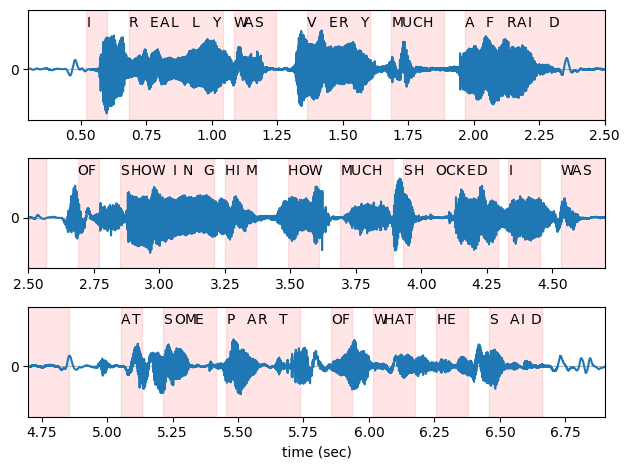

In [ ]:
def plot_alignments(waveform, emission, tokens, timesteps, sample_rate):

    t = torch.arange(waveform.size(0)) / sample_rate
    ratio = waveform.size(0) / emission.size(1) / sample_rate

    chars = []
    words = []
    word_start = None
    for token, timestep in zip(tokens, timesteps * ratio):
        if token == "|":
            if word_start is not None:
                words.append((word_start, timestep))
            word_start = None
        else:
            chars.append((token, timestep))
            if word_start is None:
                word_start = timestep

    fig, axes = plt.subplots(3, 1)

    def _plot(ax, xlim):
        ax.plot(t, waveform)
        for token, timestep in chars:
            ax.annotate(token.upper(), (timestep, 0.5))
        for word_start, word_end in words:
            ax.axvspan(word_start, word_end, alpha=0.1, color="red")
        ax.set_ylim(-0.6, 0.7)
        ax.set_yticks([0])
        ax.grid(True, axis="y")
        ax.set_xlim(xlim)

    _plot(axes[0], (0.3, 2.5))
    _plot(axes[1], (2.5, 4.7))
    _plot(axes[2], (4.7, 6.9))
    axes[2].set_xlabel("time (sec)")
    fig.tight_layout()


plot_alignments(waveform_tensor, emission, predicted_tokens, timesteps, 16000)

In [ ]:
# Load a sample from the LibriSpeech test-other dataset.
speech_file = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
IPython.display.Audio(speech_file)

In [ ]:
waveform, _ = torchaudio.load(speech_file)

waveform = get_featurizer()(waveform)
waveform = waveform.permute(0, 2, 1)
print(waveform.shape)

torch.Size([1, 341, 80])


In [ ]:
original_transcript = "i had that curiosity beside me at this moment"
actual_transcript = original_transcript.split()

emission = acoustic_model(waveform)
emission

tensor([[[-1.6138e+00, -5.1925e+00, -3.2695e-01,  ..., -9.6553e-01,
          -3.5472e+00,  9.7825e+00],
         [-1.9946e+00, -6.9646e+00, -2.9511e-01,  ..., -1.7643e+00,
          -6.0700e+00,  1.3110e+01],
         [-1.6286e+00, -6.8181e+00,  7.0908e-03,  ..., -2.8047e+00,
          -6.7352e+00,  1.3983e+01],
         ...,
         [ 6.2520e-01, -2.6482e+00, -4.4185e+00,  ..., -5.6097e+00,
          -6.7071e+00,  5.3660e+00],
         [ 7.3092e-01,  9.3218e-01, -2.6423e+00,  ..., -2.8745e+00,
          -5.8855e+00,  1.0657e+01],
         [-1.9011e+00,  3.0948e+00,  7.0055e-01,  ..., -2.7773e+00,
          -6.7956e+00,  1.2489e+01]]], grad_fn=<ViewBackward0>)

In [ ]:
beam_search_result = beam_search_decoder(emission)
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(
    actual_transcript
)

print(f"{Color.YELLOW}Orig_trans: {original_transcript}{Color.RESET}")
print(f"{Color.CYAN}Transcript: {beam_search_transcript}{Color.RESET}")
print(f"{Color.GREEN}WER: {round(beam_search_wer, 4)}{Color.RESET}\n")

Orig_trans: i had that curiosity beside me at this moment
Transcript: i had that curiosity beside me at this moment
WER: 0.0



## Download `dev-clean` from librispeech corpus for Inferencing

In [ ]:
!wget -O dev-clean.tar.gz https://us.openslr.org/resources/12/dev-clean.tar.gz
!tar -xzf dev-clean.tar.gz

--2024-11-07 06:02:18--  https://us.openslr.org/resources/12/dev-clean.tar.gz
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application/x-gzip]
Saving to: ‘dev-clean.tar.gz’

dev-clean.tar.gz    100%[===================>] 322.27M  29.8MB/s    in 12s     

2024-11-07 06:02:31 (27.2 MB/s) - ‘dev-clean.tar.gz’ saved [337926286/337926286]



In [ ]:
import os

def get_audio_paths(data_dir):
    audio_paths = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.flac'):
                audio_paths.append(os.path.join(root, file))
    return audio_paths

# Extract paths from the dev-clean folder
audio_paths = get_audio_paths('/content/LibriSpeech/dev-clean')

In [ ]:
audio_path_0 = audio_paths[0]
audio_path_5 = audio_paths[5]
audio_path_10 = audio_paths[10]
audio_path_100 = audio_paths[100]
audio_path_200 = audio_paths[200]

transcription = """
AT THE USUAL HOUR MISTER DORRIFORTH AND HIS WARD WERE SUMMONED TO TEA HE ENTERED WITH A COUNTENANCE WHICH EVINCED THE REMAINS OF ANGER HIS EYE GAVE TESTIMONY OF HIS ABSENT THOUGHTS AND THOUGH HE TOOK UP A PAMPHLET AFFECTING TO READ IT WAS PLAIN TO DISCERN THAT HE SCARCELY KNEW HE HELD IT IN HIS HAND
I THOUGHT MISS MILNER YOU GAVE ME YOUR WORD THAT YOU WOULD PASS THIS EVENING AT HOME
EVERY TIME HE BEHELD THE OBJECT OF HIS PASSION FOR HE STILL CONTINUED HIS VISITS THOUGH NOT SO FREQUENTLY AS HERETOFORE HE PLEADED HIS CAUSE WITH SUCH ARDOUR THAT MISS WOODLEY WHO WAS SOMETIMES PRESENT AND EVER COMPASSIONATE COULD NOT RESIST WISHING HIM SUCCESS
A PERSON WOULD THINK THAT AFTER A FAMILY HAD LIVED SO LONG IN A PLACE ALL THE NEIGHBORS WOULD BE FOND OF THEM YET IT IS NOT SO
THESE PERSONS THEN DISPLAYED TOWARDS EACH OTHER PRECISELY THE SAME PUERILE JEALOUSIES WHICH ANIMATE THE MEN OF DEMOCRACIES THE SAME EAGERNESS TO SNATCH THE SMALLEST ADVANTAGES WHICH THEIR EQUALS CONTESTED AND THE SAME DESIRE TO PARADE OSTENTATIOUSLY THOSE OF WHICH THEY WERE IN POSSESSION
"""

In [ ]:
# Print the list of lowercase sentences
transcription_list = [sentence.strip().lower() for sentence in transcription.split('\n') if sentence.strip()]
print(transcription_list)

['at the usual hour mister dorriforth and his ward were summoned to tea he entered with a countenance which evinced the remains of anger his eye gave testimony of his absent thoughts and though he took up a pamphlet affecting to read it was plain to discern that he scarcely knew he held it in his hand', 'i thought miss milner you gave me your word that you would pass this evening at home', 'every time he beheld the object of his passion for he still continued his visits though not so frequently as heretofore he pleaded his cause with such ardour that miss woodley who was sometimes present and ever compassionate could not resist wishing him success', 'a person would think that after a family had lived so long in a place all the neighbors would be fond of them yet it is not so', 'these persons then displayed towards each other precisely the same puerile jealousies which animate the men of democracies the same eagerness to snatch the smallest advantages which their equals contested and th

In [ ]:
audio_list = [audio_path_0,
              audio_path_5,
              audio_path_10,
              audio_path_100,
              audio_path_200]

In [ ]:
from IPython.display import Audio

for audio_file in audio_list:
    display(Audio(audio_file))

In [ ]:
# Beam Search
beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=tokens,
    lm=files.lm,
    nbest=3,
    beam_size=5,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [ ]:
for idx, (speech_file, original_transcript) in enumerate(zip(audio_list, transcription_list)):
    waveform, _ = torchaudio.load(speech_file)
    waveform = get_featurizer()(waveform)
    waveform = waveform.permute(0, 2, 1)

    # Actual words split into list
    actual_transcript = original_transcript.split()

    # Join words for CER calculation
    actual_transcript_str = ''.join(actual_transcript)

    emission = acoustic_model(waveform)

    # Beam search
    beam_search_result = beam_search_decoder(emission)
    beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()

    # Calculate WER for beam search
    beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(actual_transcript)

    # Calculate CER for beam search
    predicted_transcript_str = ''.join(beam_search_result[0][0].words)  # Join predicted words for CER
    beam_search_cer = torchaudio.functional.edit_distance(actual_transcript_str, predicted_transcript_str) / len(actual_transcript_str)

    print(f"{Color.YELLOW}Orig_trans: {original_transcript}{Color.RESET}")
    print(f"{Color.CYAN}Transcript: {beam_search_transcript}{Color.RESET}")
    print(f"{Color.GREEN}BEAM WER: {round(beam_search_wer, 4)} \t BEAM CER: {round(beam_search_cer, 4)}{Color.RESET}\n")

Orig_trans: at the usual hour mister dorriforth and his ward were summoned to tea he entered with a countenance which evinced the remains of anger his eye gave testimony of his absent thoughts and though he took up a pamphlet affecting to read it was plain to discern that he scarcely knew he held it in his hand
Transcript: at the usual hour mister dorothea his word were summoned to tea he entered with a countenance which in thereafter his eye gave testimony of his absent thoughts and though he took up a panther affecting to read it was plain to discern that he scarcely now he held it in his hand
BEAM WER: 0.1754 	 BEAM CER: 0.1107

Orig_trans: i thought miss milner you gave me your word that you would pass this evening at home
Transcript: i thought miss miller you gave me your word that you would pass this evening at home
BEAM WER: 0.0588 	 BEAM CER: 0.0147

Orig_trans: every time he beheld the object of his passion for he still continued his visits though not so frequently as heretofo

| Method                          | Average WER | Average CER |
|----------------------------------|-------------|-------------|
| **Beam Search**                  | 0.1066      | 0.0508      |


In [ ]:
beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=tokens,
    lm=files.lm,
    nbest=3,
    beam_size=10,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [ ]:
for idx, (speech_file, original_transcript) in enumerate(zip(audio_list, transcription_list)):
    waveform, _ = torchaudio.load(speech_file)
    waveform = get_featurizer()(waveform)
    waveform = waveform.permute(0, 2, 1)

    # Actual words split into list
    actual_transcript = original_transcript.split()

    # Join words for CER calculation
    actual_transcript_str = ''.join(actual_transcript)
    emission = acoustic_model(waveform)

    # Beam search
    beam_search_result = beam_search_decoder(emission)
    beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()

    beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(actual_transcript)
    predicted_transcript_str = ''.join(beam_search_result[0][0].words)  # Join predicted words for CER
    beam_search_cer = torchaudio.functional.edit_distance(actual_transcript_str, predicted_transcript_str) / len(actual_transcript_str)

    print(f"{Color.YELLOW}Orig_trans: {original_transcript}{Color.RESET}")
    print(f"{Color.CYAN}Transcript: {beam_search_transcript}{Color.RESET}")
    print(f"{Color.GREEN}BEAM WER: {round(beam_search_wer, 4)} \t BEAM CER: {round(beam_search_cer, 4)}{Color.RESET}\n")

Orig_trans: at the usual hour mister dorriforth and his ward were summoned to tea he entered with a countenance which evinced the remains of anger his eye gave testimony of his absent thoughts and though he took up a pamphlet affecting to read it was plain to discern that he scarcely knew he held it in his hand
Transcript: at the usual hour mister doors and his word were summoned to tea he entered with a countenance which even the remains of anger his eye gave testimony of his absent thoughts and though he took up a panther affecting to read it was plain to discern that he scarcely knew he held it in his hand
BEAM WER: 0.0702 	 BEAM CER: 0.0615

Orig_trans: i thought miss milner you gave me your word that you would pass this evening at home
Transcript: i thought miss miller you gave me your word that you would pass this evening at home
BEAM WER: 0.0588 	 BEAM CER: 0.0147

Orig_trans: every time he beheld the object of his passion for he still continued his visits though not so frequent

| Method                          | Average WER | Average CER |
|----------------------------------|-------------|-------------|
| **Beam Search**                  | 0.0602      | 0.0303      |


In [ ]:
beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=tokens,
    lm=files.lm,
    nbest=5,
    beam_size=100,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [ ]:
for idx, (speech_file, original_transcript) in enumerate(zip(audio_list, transcription_list)):
    waveform, _ = torchaudio.load(speech_file)
    waveform = get_featurizer()(waveform)
    waveform = waveform.permute(0, 2, 1)

    actual_transcript = original_transcript.split()
    actual_transcript_str = ''.join(actual_transcript)

    emission = acoustic_model(waveform)

    # Greedy
    greedy_result = greedy_decoder(emission[0])
    greedy_transcript = " ".join(greedy_result)

    greedy_wer = torchaudio.functional.edit_distance(actual_transcript, greedy_result) / len(actual_transcript)
    predicted_transcript_str = ''.join(greedy_result)
    greedy_cer = torchaudio.functional.edit_distance(actual_transcript_str, predicted_transcript_str) / len(actual_transcript_str)

    # Beam search
    beam_search_result = beam_search_decoder(emission)
    beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()

    beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(actual_transcript)
    predicted_transcript_str = ''.join(beam_search_result[0][0].words)  # Join predicted words for CER
    beam_search_cer = torchaudio.functional.edit_distance(actual_transcript_str, predicted_transcript_str) / len(actual_transcript_str)

    print(f"{Color.YELLOW}Orig_trans: {original_transcript}{Color.RESET}")
    print(f"{Color.CYAN}Gred_trans: {greedy_transcript}{Color.RESET}")
    print(f"{Color.CYAN}Transcript: {beam_search_transcript}{Color.RESET}")
    print(f"{Color.GREEN}GREEDY WER: {round(greedy_wer, 4)} \t GREEDY CER: {round(greedy_cer, 4)}{Color.RESET}")
    print(f"{Color.GREEN}BEAM WER: {round(beam_search_wer, 4)} \t BEAM CER: {round(beam_search_cer, 4)}{Color.RESET}\n")

Orig_trans: at the usual hour mister dorriforth and his ward were summoned to tea he entered with a countenance which evinced the remains of anger his eye gave testimony of his absent thoughts and though he took up a pamphlet affecting to read it was plain to discern that he scarcely knew he held it in his hand
Gred_trans: at the usual hour mister dorforth and his word were summoned to tea he entered with a countenance which evinced the remains of anger his eye gave testimony of his absent thoughts and though he took up a panthlet effecting to read it was plain to discern that he scarcely new he held it in his hand
Transcript: at the usual hour mister dorriforth and his word were summoned to tea he entered with a countenance which evinced the remains of anger his eye gave testimony of his absent thoughts and though he took up a panther affecting to read it was plain to discern that he scarcely knew he held in his hand
GREEDY WER: 0.0877 	 GREEDY CER: 0.0287
BEAM WER: 0.0526 	 BEAM CER:

| Method                          | Average WER | Average CER |
|----------------------------------|-------------|-------------|
| **Beam Search**                   |0.0431	| 0.0172


## Conclusion

| Method                        | nbest | beam_size | Average WER | Average CER |
|-------------------------------|-------|-----------|-------------|-------------|
| **Greedy Decoding**            | N/A   | N/A       | 0.0890      | 0.0234      |
| **Beam Search**                | 3     | 5         | 0.1066      | 0.0508      |
| **Beam Search**                | 3     | 10        | 0.0602      | 0.0303      |
| **Beam Search**                | 5     | 100       | 0.0431      | 0.0172      |

Achieving a strong **8.90% WER** with **greedy decoding** was just the beginning! 😎 By switching to **Beam Search**, we observed a slight increase in WER at first with a smaller beam size (**10.66% WER at beam size 5**), but as we increased the beam size and `nbest`, the performance dramatically improved, dropping to an impressive **4.31% WER at beam size 100**! 🚀 This shows that fine-tuning the beam parameters can lead to more precise predictions, though at the cost of increased computation time. ⏳



